# Семинар 4: Методы оптимизации, PyTorch Lightning

## Вступление
На предыдущем курсе мы обсуждали с вами методы градиентного спуска и стохастического градиентного спуска. Для нейронных сетей обычно используют более продвинутые методы оптимизации, которые основаны на известном нам градиентном спуске. Сегодня мы посмотрим на то, как использовать их в **PyTorch**, а также разберём библиотеку **PyTorch Lightning**, позволяющую сократить количество кода, которое нам приходится писать на **PyTorch**.

### План семинара
1. Оптимизируем функцию одной переменной в **PyTorch**
2. Изучаем разные методы оптимизации
3. Работаем с PyTorch Optimizer
4. Работаем с PyTorch Scheduler
5. PyTorch VS PyTorch Lightning
6. Сравнением работу разных оптимизаторов

In [1]:
!pip install pytorch_lightning torchmetrics torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## PyTorch VS PyTorch Lightning

**PyTorch Lightning** это фреймворк для организованной работы с **PyTorch**. В нем упрощена работа по:
- Написанию тренировочного цикла
- Написанию датасетов
- Использованию gpu/tpu/ipu/hpu и тд
- Переводу моделей в формат ONNX
- И многому другому

Фреймворк призван оставить юзеру возможность конфигурировать параметры и проводить эксперименты, а остальное он возьмет на себя. Давайте сравним код на **PyTorch** без и с использованием **Lightning** на примере несложной нейросети на датасете FashionMNIST.

In [4]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# крутая библиотека с кучей метрик "из коробки"
from torchmetrics.functional import accuracy

### Данные (общее)

In [5]:
# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Ankle Boot


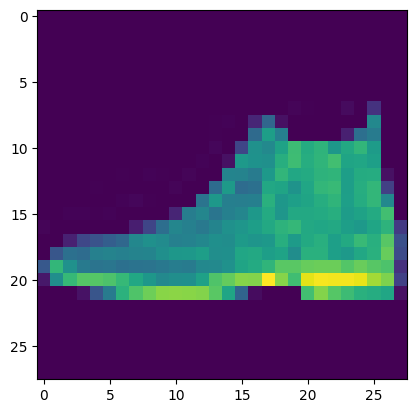

Coat


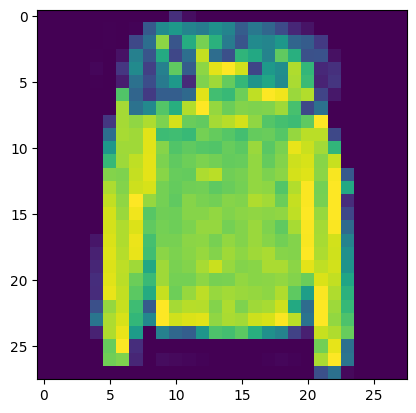

In [7]:
### pictures are normalized
for batch in val_dataloader:
    # batch_size is 128
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    plt.show()
    break

### Модель (общее)

Создайте класс модели по следующей схеме:

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLu -> MaxPool(kernel=2)
3. BatchNorm
4. Conv(out=64, kernel=3) -> ReLu -> MaxPool(kernel=2)
5. Flatten
6. Linear(out=128)
7. ReLu
8. Dropout
9. Linear(out=64)
10. ReLu
11. Linear(out=10)

In [8]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm1 = torch.nn.BatchNorm2d(1)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)

        self.output = torch.nn.Linear(in_features=64, out_features=10)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(
                self.preds.long(),
                self.targets.long(),
                task="multiclass",
                num_classes=10,
            )

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Гиперпараметры

In [9]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

### Тренировочные циклы (PyTorch)

Здесь нам надо будет объявить функции `train_epoch`, `validate`, `fit`.
Структура, напомним, выглядит, в упрощенном виде, так:
```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```
Но на деле это все намного сложнее:

In [10]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [11]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [12]:
# проверим, что всё работает (±1 минута на гпу):
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=1,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.179 Accuracy: 23.7567: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s]
Validation Epoch: 0
Loss: 2.1955 Accuracy: 51.46: 100%|██████████| 79/79 [00:01<00:00, 69.18it/s]


### Тренировочные циклы (Lightning)

Здесь будет немного другая структура.

1) Создается 1 класс отнаследованный от `pl.LightningModule`. В нем описывается сама модель, необходимые функции тренировчного и валидационного шага.

2) Создается объект класса `pl.Trainer` с параметрами (напр. номер гпу, кол-во эпох, град. клиппинг и так далее) дока [тут](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) или [тут](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `SimpleNet`, то исправлять нам много не надо.

In [13]:
# 1) create a LightningModule


class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # сохраняет логи в папку, но можно несложно добавить wandb
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [14]:
# 2) create module


model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer(accelerator="cpu", max_epochs=1)
trainer.fit(module, train_dataloader, val_dataloader)

# 3.5) we can also find best learning rate like this: https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html
# trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)
# trainer.tune(module, train_dataloader, eval_dataloader)
# trainer.fit(module, train_dataloader, eval_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleNet | 232 K  | train
--------------------------------------------
232 K     Trainable params
0         Non-trainable params
232 K     Total params
0.931     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Обратите внимание **насколько** поведение `trainer.fit()` сильно похоже на написанную нами ранее функцию `fit()`


Заметьте также, что на Lightning мы:
1.   Не описывали тренировочный цикл ни по эпохам, ни по батчам
2.   Не рисковали забыть zero_grad, .backward()
3.   Не переносили ни модель, ни данные на GPU
4.   Получили всякие приколы типа auto_lr_find
5.   Сохранили возможность использования многих тонкостей **PyTorch** типа [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), логирование через [wandb](https://docs.wandb.ai/guides/integrations/lightning) и так далее

## Сравнением работу разных оптимизаторов

### SGD

In [15]:
model = SimpleNet().to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 2.1719 Accuracy: 19.68: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
Validation Epoch: 0
Loss: 2.1626 Accuracy: 45.1: 100%|██████████| 79/79 [00:01<00:00, 63.59it/s]
Train Epoch: 1
Loss: 1.8494 Accuracy: 37.8733: 100%|██████████| 469/469 [00:10<00:00, 45.12it/s]
Validation Epoch: 1
Loss: 1.8677 Accuracy: 52.67: 100%|██████████| 79/79 [00:01<00:00, 57.34it/s]
Train Epoch: 2
Loss: 1.589 Accuracy: 49.8267: 100%|██████████| 469/469 [00:10<00:00, 45.00it/s]
Validation Epoch: 2
Loss: 1.3678 Accuracy: 66.02: 100%|██████████| 79/79 [00:01<00:00, 63.61it/s]
Train Epoch: 3
Loss: 1.0943 Accuracy: 58.9167: 100%|██████████| 469/469 [00:10<00:00, 44.98it/s]
Validation Epoch: 3
Loss: 0.9442 Accuracy: 68.08: 100%|██████████| 79/79 [00:01<00:00, 62.97it/s]
Train Epoch: 4
Loss: 1.0506 Accuracy: 62.9067: 100%|██████████| 469/469 [00:10<00:00, 44.14it/s]
Validation Epoch: 4
Loss: 0.7134 Accuracy: 70.1: 100%|██████████| 79/79 [00:01<00:00, 64.43it/s]
Train Epoch: 5
Loss: 1.032 Acc

### SGD with Momentum

In [16]:
model = SimpleNet().to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.6768 Accuracy: 55.255: 100%|██████████| 469/469 [00:09<00:00, 47.57it/s]
Validation Epoch: 0
Loss: 0.4967 Accuracy: 73.25: 100%|██████████| 79/79 [00:01<00:00, 44.89it/s]
Train Epoch: 1
Loss: 0.6456 Accuracy: 75.6783: 100%|██████████| 469/469 [00:09<00:00, 49.26it/s]
Validation Epoch: 1
Loss: 0.3433 Accuracy: 78.25: 100%|██████████| 79/79 [00:01<00:00, 45.14it/s]
Train Epoch: 2
Loss: 0.6184 Accuracy: 79.765: 100%|██████████| 469/469 [00:09<00:00, 48.09it/s]
Validation Epoch: 2
Loss: 0.2653 Accuracy: 81.6: 100%|██████████| 79/79 [00:01<00:00, 52.31it/s]
Train Epoch: 3
Loss: 0.459 Accuracy: 82.1183: 100%|██████████| 469/469 [00:10<00:00, 46.34it/s]
Validation Epoch: 3
Loss: 0.2011 Accuracy: 83.95: 100%|██████████| 79/79 [00:01<00:00, 56.21it/s]
Train Epoch: 4
Loss: 0.4171 Accuracy: 83.995: 100%|██████████| 469/469 [00:10<00:00, 45.02it/s]
Validation Epoch: 4
Loss: 0.1449 Accuracy: 84.91: 100%|██████████| 79/79 [00:01<00:00, 58.35it/s]
Train Epoch: 5
Loss: 0.3434 Ac

### RMSprop

In [17]:
model = SimpleNet().to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.3628 Accuracy: 80.8883: 100%|██████████| 469/469 [00:10<00:00, 44.65it/s]
Validation Epoch: 0
Loss: 0.1698 Accuracy: 86.84: 100%|██████████| 79/79 [00:01<00:00, 63.85it/s]
Train Epoch: 1
Loss: 0.2066 Accuracy: 87.43: 100%|██████████| 469/469 [00:10<00:00, 44.29it/s]
Validation Epoch: 1
Loss: 0.1543 Accuracy: 88.29: 100%|██████████| 79/79 [00:01<00:00, 64.41it/s]
Train Epoch: 2
Loss: 0.302 Accuracy: 89.0: 100%|██████████| 469/469 [00:10<00:00, 43.98it/s]
Validation Epoch: 2
Loss: 0.174 Accuracy: 89.01: 100%|██████████| 79/79 [00:01<00:00, 63.26it/s]
Train Epoch: 3
Loss: 0.2269 Accuracy: 89.94: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]
Validation Epoch: 3
Loss: 0.1251 Accuracy: 90.09: 100%|██████████| 79/79 [00:01<00:00, 64.40it/s]
Train Epoch: 4
Loss: 0.314 Accuracy: 90.6667: 100%|██████████| 469/469 [00:10<00:00, 44.09it/s]
Validation Epoch: 4
Loss: 0.2074 Accuracy: 90.02: 100%|██████████| 79/79 [00:01<00:00, 63.68it/s]
Train Epoch: 5
Loss: 0.2204 Accurac

### Adam

In [18]:
model = SimpleNet().to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.2542 Accuracy: 80.8067: 100%|██████████| 469/469 [00:09<00:00, 49.25it/s]
Validation Epoch: 0
Loss: 0.1457 Accuracy: 86.18: 100%|██████████| 79/79 [00:01<00:00, 45.89it/s]
Train Epoch: 1
Loss: 0.3016 Accuracy: 87.375: 100%|██████████| 469/469 [00:09<00:00, 48.95it/s]
Validation Epoch: 1
Loss: 0.137 Accuracy: 89.42: 100%|██████████| 79/79 [00:01<00:00, 54.73it/s]
Train Epoch: 2
Loss: 0.2012 Accuracy: 89.0867: 100%|██████████| 469/469 [00:10<00:00, 46.17it/s]
Validation Epoch: 2
Loss: 0.1244 Accuracy: 89.06: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]
Train Epoch: 3
Loss: 0.4893 Accuracy: 90.1883: 100%|██████████| 469/469 [00:10<00:00, 46.37it/s]
Validation Epoch: 3
Loss: 0.0971 Accuracy: 90.0: 100%|██████████| 79/79 [00:01<00:00, 63.42it/s]
Train Epoch: 4
Loss: 0.2852 Accuracy: 91.1017: 100%|██████████| 469/469 [00:13<00:00, 35.85it/s]
Validation Epoch: 4
Loss: 0.1064 Accuracy: 90.46: 100%|██████████| 79/79 [00:01<00:00, 43.27it/s]
Train Epoch: 5
Loss: 0.317 A

### Adam + Scheduler

In [19]:
model = SimpleNet().to(device=device)
lambda_func = lambda epoch: 0.975**epoch
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
adam_scheduler_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

Train Epoch: 0
Loss: 0.3619 Accuracy: 80.3033: 100%|██████████| 469/469 [00:09<00:00, 49.11it/s]
Validation Epoch: 0
Loss: 0.274 Accuracy: 86.55: 100%|██████████| 79/79 [00:01<00:00, 47.32it/s]
Train Epoch: 1
Loss: 0.3072 Accuracy: 87.61: 100%|██████████| 469/469 [00:09<00:00, 48.48it/s]
Validation Epoch: 1
Loss: 0.1699 Accuracy: 88.68: 100%|██████████| 79/79 [00:01<00:00, 56.62it/s]
Train Epoch: 2
Loss: 0.2207 Accuracy: 89.1167: 100%|██████████| 469/469 [00:10<00:00, 46.55it/s]
Validation Epoch: 2
Loss: 0.1337 Accuracy: 89.42: 100%|██████████| 79/79 [00:01<00:00, 62.76it/s]
Train Epoch: 3
Loss: 0.2377 Accuracy: 90.2567: 100%|██████████| 469/469 [00:11<00:00, 42.53it/s]
Validation Epoch: 3
Loss: 0.0768 Accuracy: 90.49: 100%|██████████| 79/79 [00:01<00:00, 63.51it/s]
Train Epoch: 4
Loss: 0.231 Accuracy: 91.0467: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s]
Validation Epoch: 4
Loss: 0.1467 Accuracy: 90.48: 100%|██████████| 79/79 [00:01<00:00, 63.51it/s]
Train Epoch: 5
Loss: 0.1147 A

На валидации получается значение несколько лучше, чем у просто Adam.

### Графики падения лосса при разных способах оптимизации

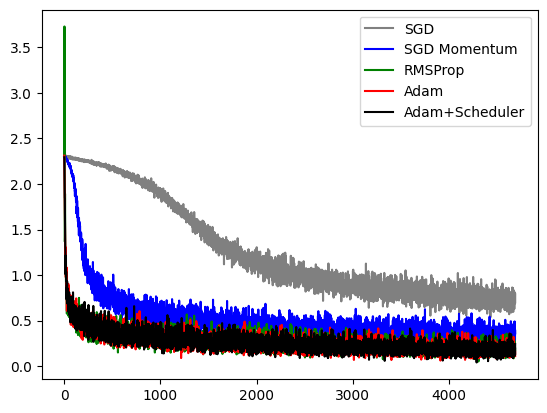

In [20]:
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_loss_info.full_train_losses,
    label="SGD",
    c="grey",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    sgd_momentum_loss_info.full_train_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    rmsprop_loss_info.full_train_losses,
    label="RMSProp",
    c="green",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_loss_info.full_train_losses,
    label="Adam",
    c="red",
)
plt.plot(
    np.arange(len(train_dataloader) * 10),
    adam_scheduler_loss_info.full_train_losses,
    label="Adam+Scheduler",
    c="black",
)

plt.legend()
plt.show()

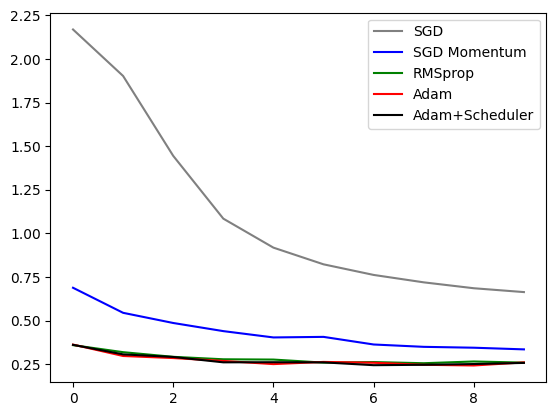

In [21]:
plt.plot(np.arange(10), sgd_loss_info.eval_epoch_losses, label="SGD", c="grey")
plt.plot(
    np.arange(10),
    sgd_momentum_loss_info.eval_epoch_losses,
    label="SGD Momentum",
    c="blue",
)
plt.plot(np.arange(10), rmsprop_loss_info.eval_epoch_losses, label="RMSprop", c="green")
plt.plot(np.arange(10), adam_loss_info.eval_epoch_losses, label="Adam", c="red")
plt.plot(
    np.arange(10),
    adam_scheduler_loss_info.eval_epoch_losses,
    label="Adam+Scheduler",
    c="black",
)
plt.legend()
plt.show()